In [1]:
include("Taylor.jl")
using TS
using PyPlot
using Interact

In [2]:
function IntTaylor{T}(t0::Real, tf::Real, x0::Array{T,1},F::Array{Function,1},p::Int)    
    
    #Definimos primero las variables de salida
    t = Float64[];
    x = Array{T,1}[];
    h = Float64[];
     
    
    # Empezamos los Taylors con la condición inicial.
    xT = Taylor{T}[];

    #Inicializamos los vectores de tiempo y de las variables
    push!(t,t0);
    for i = 1:length(x0)
        push!(xT,Taylor(x0[i]))
        push!(x,[x0[i]])
    end

    
    
    # Ejecutamos mientras que el tiempo inicial sea menor al final.    
    while t0 <= tf;        
    #Primero encontramos los polinomios de Taylor de orden p para cada variable
        for i = 1:p
            for j = 1:length(F)
                xT[j] = Taylor(push!(xT[j].taylor_vec,F[j](xT).taylor_vec[i]/i));
            end
        end
        
        #Buscamos el valor de h que mejor se ajuste para cumplir la condición de la epsilon   
        hl = Float64[];
        for i = 1:length(F)
            push!(hl,(1/2)*(eps(1.0)/abs(xT[i].taylor_vec[p]))^(1/(p-1)));
            push!(hl,(1/2)*(eps(1.0)/abs(xT[i].taylor_vec[p+1]))^(1/(p)));
        end
        h0 = minimum(hl);    
        t0 += h0;
        #Desarrollamos para el nuevo tiempo por medio del método de Horner. Estamos buscando la nueva x0
        

        for i=1:length(x0)
            s0=xT[i].taylor_vec[p+1];
            for j=1:p
                s0=xT[i].taylor_vec[p+1-j]+h0*s0;
            end
            x0[i]=s0;
        end
        
        
        push!(h,h0)
        push!(t,t0);
        for i=1:length(x0)
            xT[i]=Taylor(x0[i]);
            push!(x[i],x0[i])
        end
        
    end
    return t,x,h

end

IntTaylor (generic function with 1 method)

In [16]:
σ=10;
β=8/3;
ρ=28;
f(x)=σ*(x[2]-x[1])
g(x)=ρ*x[1]-x[2]-x[1]*x[3]
h(x)=x[1]*x[2]-β*x[3]
t0=0.0;
tf=300.0;
x0=[0.1,0.1,0.1];
F=[f,g,h];
p=20;
 
a=IntTaylor(t0,tf,x0,F,p);



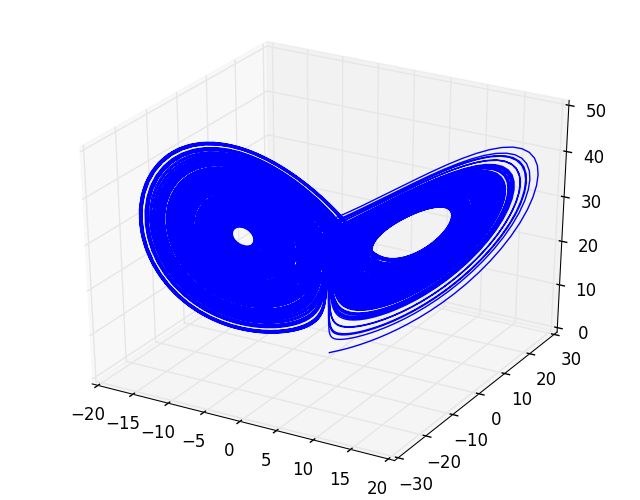

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7fd4a4a9af60>

In [17]:
plot3D(a[2][1],a[2][2],a[2][3])

In [76]:
"""
## Conteo fractal.
La función conteo_fractal(x,r) toma una lista x que contiene 3 arreglos de datos que 
corresponden a la solución en el espacio fase de un sistema de ecuaciones diferenciales. 
La función identifica el tamaño que la solución ocupa y posteriormente divide este espacio
en rxrxr cubos. La función cuenta el número de cubos que poseen al menos un punto de la
solución dentro de ellos. 
"""
function conteo_fractal{T}(x::Array{Array{T,1},1},r::Int64)
    
    #En caso de que demos una partición menor que cero, atrapamos el error.
    if r<1
        error("La partición del espacio debe ser un número entero")
    end
    
    #Inicializamos un vector donde guardaremos la cota inferior para cada una de 
    #nuestras coordenadas.
    cota_inf=zeros(Float64,3);
    #Inicializamos un vector donde guardaremos el tamaño de cada caja en cada dimensión.
    tamano=zeros(Float64,3);
    #Inicializamos una matriz donde guardaremos los puntos en que hemos dividido 
    #los intervalos.
    division=zeros(Float64,3,r+1);
    #Inicializamos una matriz de 3x3x3 donde guardaremos el conteo de cajas que contienen
    #al menos un punto de la solución.
    cajas=zeros(Int64,r,r,r);
    
    
    #Guardamos las cotas inferiores y los tamaños de intervalo para cada coordenada.
    for i=1:3
        #Definimos al intervalo más pequeño como el mínimo menos un 0.5% de la distancia
        #respecto al máximo.
        cota_inf[i]=minimum(x[i])-0.005*(abs(maximum(x[i])-minimum(x[i])));
        #El tamaño total del intervalo que se estudiará se toma como 101% de la distancia
        #entre mínimo y máximo de los datos.
        tamano[i]=(abs(maximum(x[i])-minimum(x[i])))*(1.01);
    end
    
    #Guardamos los puntos en que hemos dividido los intervalos.
    for i=1:3
        division[i,1] = cota_inf[i]
        for j = 2:r+1
            division[i,j] = cota_inf[i] + abs((j-1)*tamano[i]/r);
        end
    end
    
    # Revisamos la caja correspondiente a cada uno de los elementos de la matriz de 
    # 3x3x3
    for i = 1:length(x[1])
        for j=2:r+1,k=2:r+1,l=2:r+1
            if  (  (x[1][i]<division[1,j] && x[1][i]>=division[1,j-1]) 
                && (x[2][i]<division[2,k] && x[2][i]>=division[2,k-1]) 
                && (x[3][i]<division[3,l] && x[3][i]>=division[3,l-1]))
                if cajas[j-1,k-1,l-1] != 0
                    break;
                else
                    #Si existe al menos un punto de la solución en la caja
                    #, esa caja se "llena"
                    cajas[j-1,k-1,l-1] = 1;
                end
            end
        end    
    end
    
    #Regresamos la cuenta de las cajas que poseen al menos un punto de la curva.
    return sum(cajas)
    
end

conteo_fractal (generic function with 1 method)

In [80]:
"""
## Dimensión fractal.
La función dim_fractal_cajas(x,R) toma una lista x que contiene 3 arreglos de datos que 
corresponden a la solución en el espacio fase de un sistema de ecuaciones diferenciales. 
La función utiliza la función conteo_fractal(x,r) para dividir el espacio fase
de la solución y contar el número de cajas que contienen al menos un elemento 
de la solución en su interior. Este proceso lo realiza para R tamaños de caja distintos.
Como salida se obtienen los valores de r utilizados, los valores de los conteos para cada
r y el valor de la dimensión fractal.
"""
function dim_fractal_cajas{T}(x::Array{Array{T,1},1},R::Int)
    #Se inicializa la salida de la función en ceros.
    salida=zeros(Int64,R);
    for i=1:R
        # Se guardan los valores obtenidos para cada r
        salida[i]=conteo_fractal(a[2],i)
    end
    #Se regresan los valores 
    return collect(1:R),salida,
    linreg(log(collect(1:R)),log(salida))[2]
end


dim_fractal_cajas (generic function with 1 method)

In [81]:
R,N=dim_fractal_cajas(a[2],14)

([1,2,3,4,5,6,7,8,9,10,11,12,13,14],[1,8,19,35,52,75,95,123,152,186,218,260,306,339],2.0970766161007406)

In [57]:
function dim_fractal_radios{T}(x::Array{Array{T,1},1},radio::Real)
    n=zero(Int)
    for i = 2 : length(x[1])
        for j = 1 : i-1
            if   (sqrt((x[1][i] - x[1][j])^2 
                + (x[2][i] - x[2][j])^2 
                + (x[3][i] - x[3][j])^2)< radio)
                n += 1;
            end
        end
    end
    return radio, 2*n/(length(x[1])*(length(x[1])+1))
end

dim_fractal_radios (generic function with 1 method)

In [68]:
dim_fractal_radios(a[2],0.01)

(0.01,1.3619979420211096e-7)

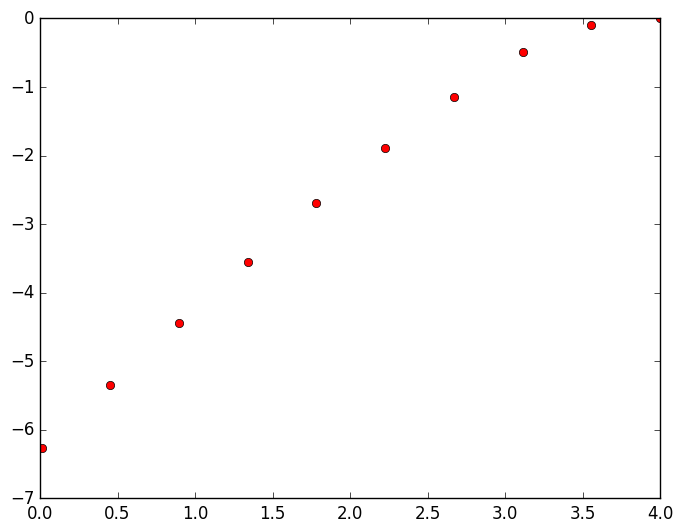

2-element Array{Float64,1}:
 -5.9019 
  1.65174

In [69]:
R=Float64[];
C=Float64[];
radios=exp(linspace(0.01,4.0,10))
for i=radios
    r,n=dim_fractal_radios(a[2],i);
    push!(R,r)
    push!(C,n)
end
plot(log(R),log(C),"ro")
linreg(log(R),log(C))
#log(N[7])-log(N[1])/log(R[7])-log(R[1])

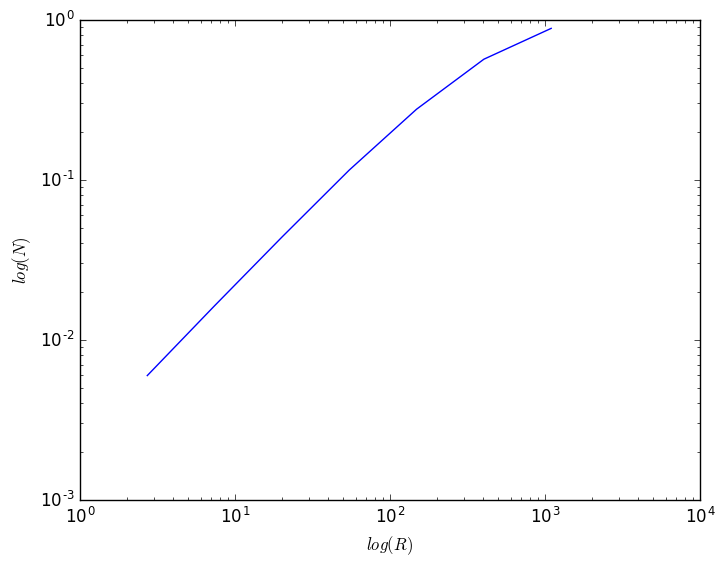

PyObject <matplotlib.text.Text object at 0x7f46b8a12dd8>

In [15]:

loglog(R,N)
xlabel(L"log(R)");
ylabel(L"log(N)");
#xlim([minimum(log(R)),maximum(log(R))])
#ylim([minimum(log(N)),maximum(log(N))])

In [16]:
(log(174)-log(1))/(log(10)-log(1))

2.2405492482825995

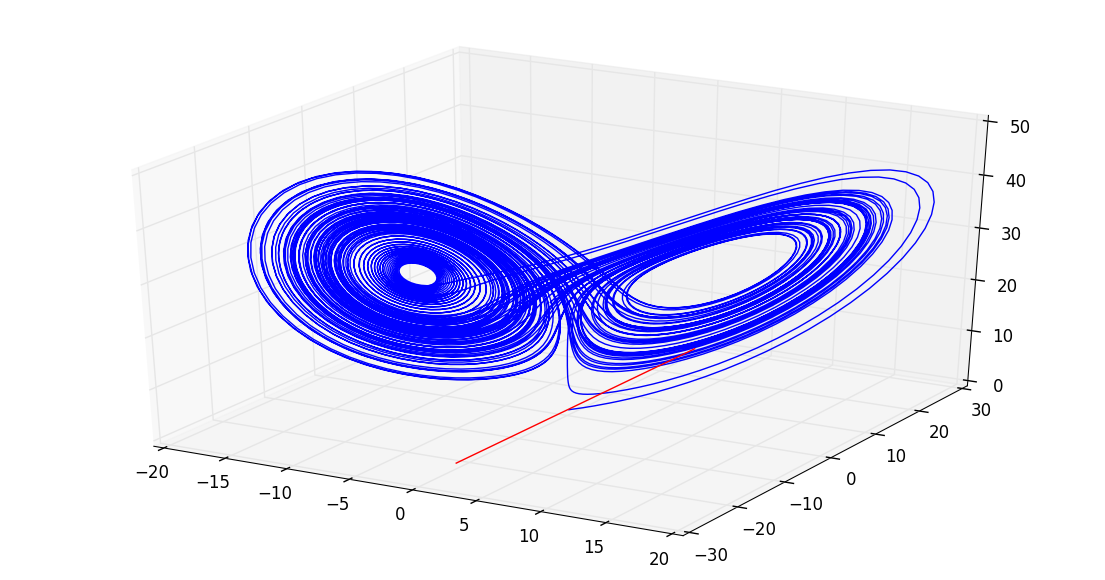

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f46b4965978>

In [17]:
fig = figure("taylor_solution", figsize=(14,7))
ylabel(L"$z(t)$");
xlabel(L"$x(t)$");
plot3D(a[2][1],a[2][2],a[2][3])
plot3D([0, 0],[minimum(a[2][2]), maximum(a[2][2])],[minimum(a[2][3]), minimum(a[2][3])],"-r")

In [ ]:
σ=10;
β=8/3;
ρ=28;
dx(x) = σ*(x[2] - x[1])
dy(x) = ρ*x[1] - x[2] - x[1]*x[3]
dz(x) = x[1]*x[2] - β*x[3]
dxx(x) = σ*(x[5] - x[4])
dxy(x) = (ρ-x[3])*x[4] - x[5] - x[1]*x[6]
dxz(x) = x[2]*x[4] + x[1]*x[5] - β*x[6]
dyx(x) = σ*(x[8] - x[7])
dyy(x) = (ρ-x[3])*x[7] - x[8] - x[1]*x[9]
dyz(x) = x[2]*x[7] + x[1]*x[8] - β*x[9]
dzx(x) = σ*(x[11] - x[10])
dzy(x) = (ρ-x[3])*x[10] - x[11] - x[1]*x[12]
dzz(x) = x[2]*x[10] + x[1]*x[11] - β*x[12]
t0=0.0;
tf=100;
x0=[0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1];
F=[dx,dy,dz,dxx,dxy,dxz,dyz,dyy,dyz,dzx,dzy,dzz];
p=20;
 
a=IntTaylor(t0,tf,x0,F,p);

In [ ]:
a

In [ ]:
a[2][4]

In [ ]:
tiempo_final=Float64[];
V=Float64[];
for tf=10:10:100
    σ=10;
    β=8/3;
    ρ=28;
    dx(x) = σ*(x[2] - x[1])
    dy(x) = ρ*x[1] - x[2] - x[1]*x[3]
    dz(x) = x[1]*x[2] - β*x[3]
    vx(x) = σ*(x[5] - x[4])
    vy(x) = (ρ-x[3])*x[4] - x[5] + x[1]*x[6]
    vz(x) = x[2]*x[4] + x[1]*x[5] - β*x[6]

    t0=0.0;
    x0=[0.1,0.1,0.1,0.1,0.1,0.1];
    F=[dx,dy,dz,vx,vy,vz];
    p=20;
    a=IntTaylor(t0,tf,x0,F,p);
    push!(V,sqrt(a[2][4][length(a[2][4])]^2+a[2][5][length(a[2][5])]^2+a[2][6][length(a[2][6])]^2));
    push!(tiempo_final,tf);
end


In [ ]:
plot(tiempo_final,V)